In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.geodesic import Geodesic
land_color = [85/255, 92/255, 105/255]
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=land_color)
plt.rcParams['axes.grid'] = True
import numpy as np
import xarray as xr
import pandas as pd
import gsw, os 
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import radians
from sklearn.metrics.pairwise import haversine_distances

In [30]:
gebco = pd.read_csv('ATL_ground_gebco_TID.csv',delimiter='\t',names=['lat','lon','ground','gebco','tid'],header=1)
tids = {10:'Singlebeam',11:'Multibeam',17:'Combination',40:'Satellite gravimetry',41:'Interpolation',
        42:'Digital contour from charts',44:'Bathymetric sounding',70:'Pre-generated grid'}
gebco['source']=[tids[f] for f in gebco['tid']]
gebco

,lat,lon,ground,gebco,tid,source
0,47.332098,-8.415112,2714.283343,-2679.404481,17,Combination
1,47.287960,-8.444420,3399.463103,-3183.478832,17,Combination
2,47.362940,-8.452200,2704.485936,-2502.158544,17,Combination
3,47.321047,-8.429085,2788.673716,-2776.535388,17,Combination
4,47.323920,-8.287320,2736.800113,-2577.158899,17,Combination
...,...,...,...,...,...,...
3923,53.646092,-26.398072,3661.664329,-3664.992291,40,Satellite gravimetry
3924,59.344160,-47.915273,3126.641297,-3132.828469,40,Satellite gravimetry
3925,50.765860,-31.440320,3721.063793,-3462.451106,40,Satellite gravimetry
3926,35.614270,-16.157740,3223.245090,-3117.911731,11,Multibeam


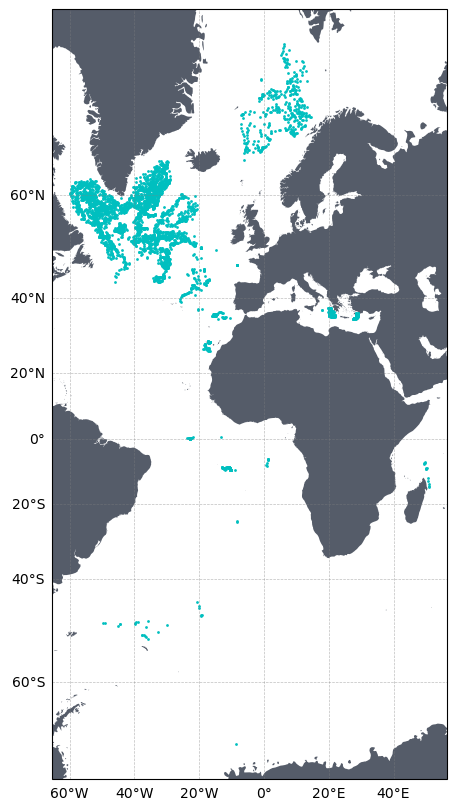

In [10]:
fig=plt.figure(figsize=(12,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.add_feature(land_feature, edgecolor=None)
ax.plot(gebco['lon'],gebco['lat'],'.c', markersize=4, markeredgecolor='None', alpha=1, transform=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER  

Text(0, 0.5, 'Bathy [m]')

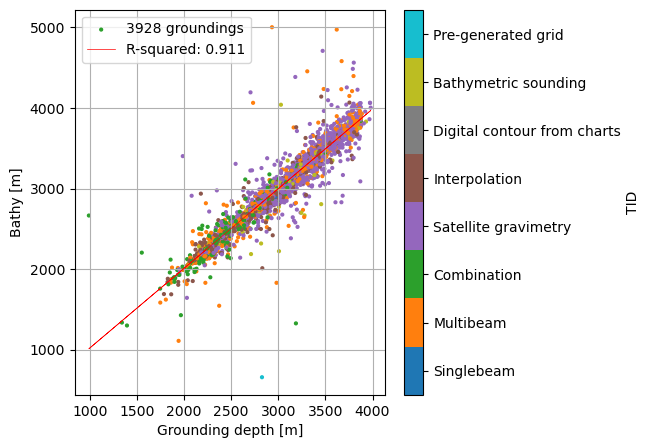

In [14]:
x=gebco['ground'].values
y=-gebco['gebco'].values
c=gebco['tid'].values
uc = np.unique(c)
sc = [tids[i] for i in uc]
cc = [np.argwhere(i==uc)[0].flatten() for i in c] 
res = stats.linregress(x, y)

fig,ax = plt.subplots(1,1,figsize=(5,5))
a=ax.scatter(x,y,s=4,c=cc,label=f"{len(x)} groundings",cmap=plt.get_cmap('tab10',len(uc)),vmin=0,vmax=8)
plt.plot(x, res.intercept + res.slope*x, 'r',linewidth=0.5,label=f"R-squared: {res.rvalue**2:.3f}")
cbar = plt.colorbar(a,label='TID')
cbar.set_ticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5],labels=sc)

#ax.set_xlim([1000,5000])
#ax.set_ylim([1000,5000])
ax.legend()
ax.set_xlabel('Grounding depth [m]')
ax.set_ylabel('Bathy [m]')
#fig.savefig('groundingVsBathy.png')

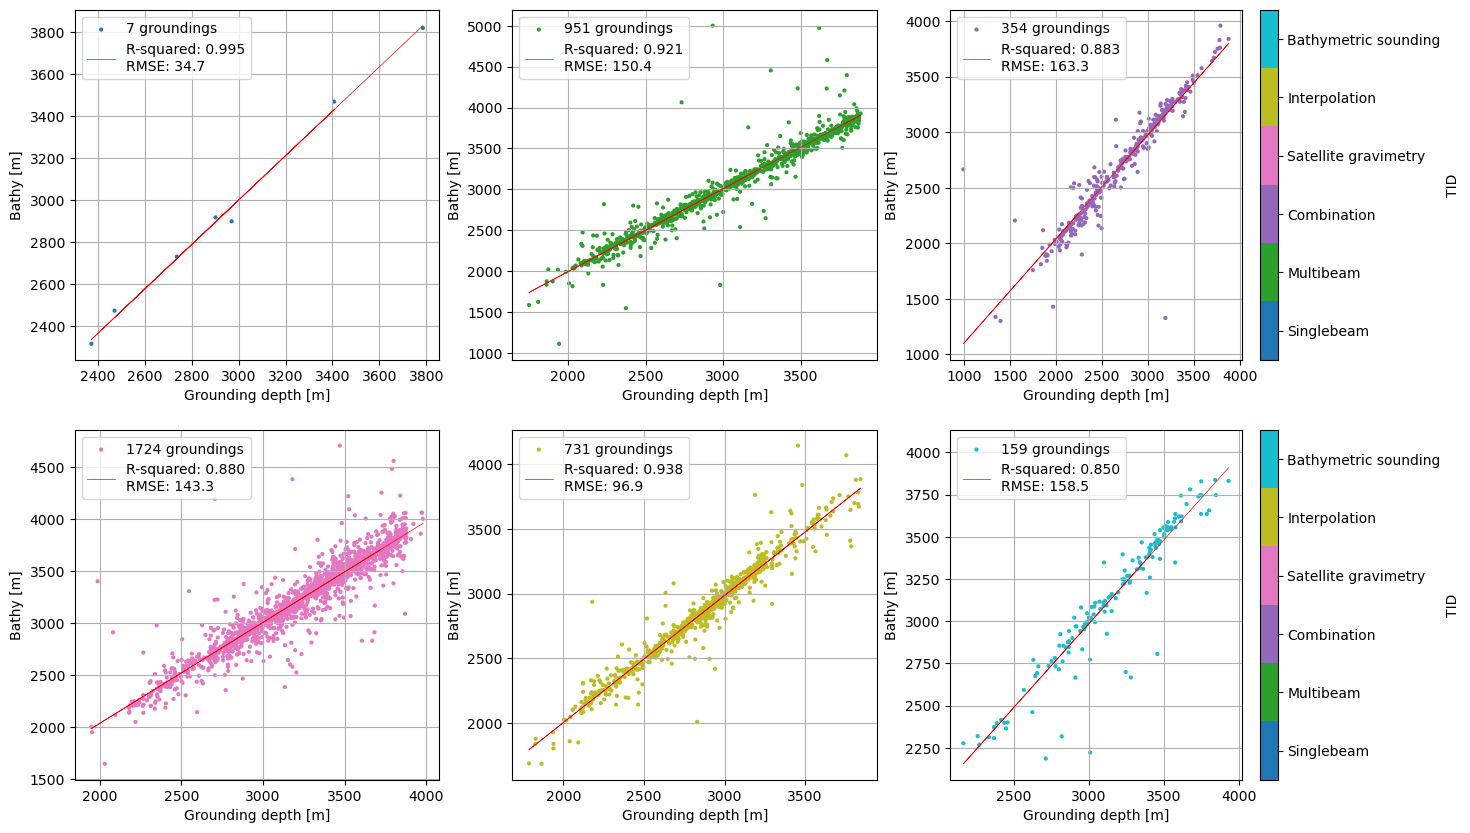

In [19]:
fig,ax = plt.subplots(2,3,figsize=(16,10))

uc = np.array([10,11,17,40,41,44]) #np.unique(c)
sc = [tids[i] for i in uc]

k=0
for t in uc:
    lk=int(np.floor(k/3))
    ck=k%3
    
    subgebco = gebco.query(f'tid=={t}')
    xs=subgebco['ground'].values
    ys=-subgebco['gebco'].values
    cs=subgebco['tid'].values    
    cc = [np.argwhere(i==uc)[0].flatten() for i in cs] 
    res = stats.linregress(xs, ys)

    a=ax[lk,ck].scatter(xs,ys,s=4,c=cc,label=f"{len(xs)} groundings",cmap=plt.get_cmap('tab10',len(uc)),vmin=0,vmax=6)
    ax[lk,ck].plot(xs, res.intercept + res.slope*xs, 'r',linewidth=0.5,label=f"R-squared: {res.rvalue**2:.3f}\nRMSE: {np.sqrt(mean_squared_error(ys, res.intercept + res.slope*xs)):.1f}")
    if ck==2:
        cbar = plt.colorbar(a,label='TID')
        cbar.set_ticks([0.5,1.5,2.5,3.5,4.5,5.5],labels=sc)
    
    ax[lk,ck].legend()
    ax[lk,ck].set_xlabel('Grounding depth [m]')
    ax[lk,ck].set_ylabel('Bathy [m]')
    k+=1

How to calculate the closest TID multibeam point to a lat/lon couple ?

In [79]:
mbgrid = xr.open_dataset('/home1/datawork/kbalem/GEBCO_2023_TID.nc')
#df1 = xr.open_dataset('working_ds.nc')

## Smallest distance to a multibeam grid point ?

In [37]:
#dist_to_mb = np.zeros(len(df1.N_GRD.values))*np.nan
dist_to_mb = np.zeros(len(gebco))*np.nan

delta_deg = [1,2,3,4,5]
for i in range(len(gebco)):
    #lat, lon = df1.isel(N_GRD=i)['LATITUDE'].values, df1.isel(N_GRD=i)['LONGITUDE'].values
    lat, lon = gebco['lat'].values[i], gebco['lon'].values[i] 
    #Select a subarray in gebco tid grid (from 1° to 10° if it does not find tid ==11)    
    for d in delta_deg:
        submgrid = mbgrid.sel(lon=slice(lon-d/2,lon+d/2),lat=slice(lat-d/2,lat+d/2))
        submgrid = submgrid.where(submgrid['tid']==11,drop=True)
        if len(submgrid.lon)>0:
            break     
    if len(submgrid.lon)==0:
        break        
    stacked_submgrid = submgrid.stack(k=('lat','lon'))
    stacked_submgrid = stacked_submgrid.dropna('k')
    around_points = np.column_stack([stacked_submgrid['lat'].values,stacked_submgrid['lon'].values])    
    result = haversine_distances(np.radians([lat,lon]).reshape(1, -1), np.radians(around_points))
    # multiply by Earth radius to get kilometers    
    dist_to_mb[i]=np.min(result)*6371000/1000

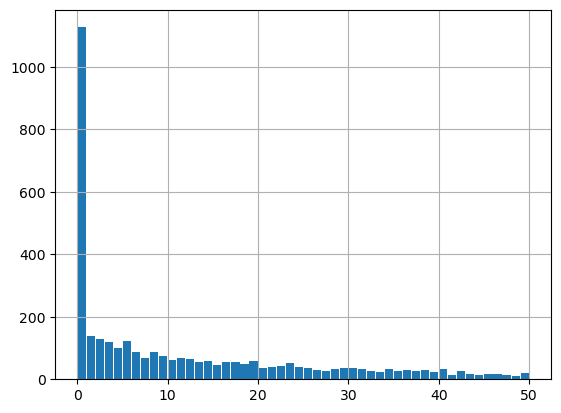

In [38]:
_ = plt.hist(dist_to_mb,bins=50,rwidth=0.9,range=[0,50])

In [9]:
#df1['mindist'] = xr.DataArray(mindist,dims='N_GRD')

In [65]:
indexz = np.argwhere((dist_to_mb>=5).astype(int)==1).flatten()

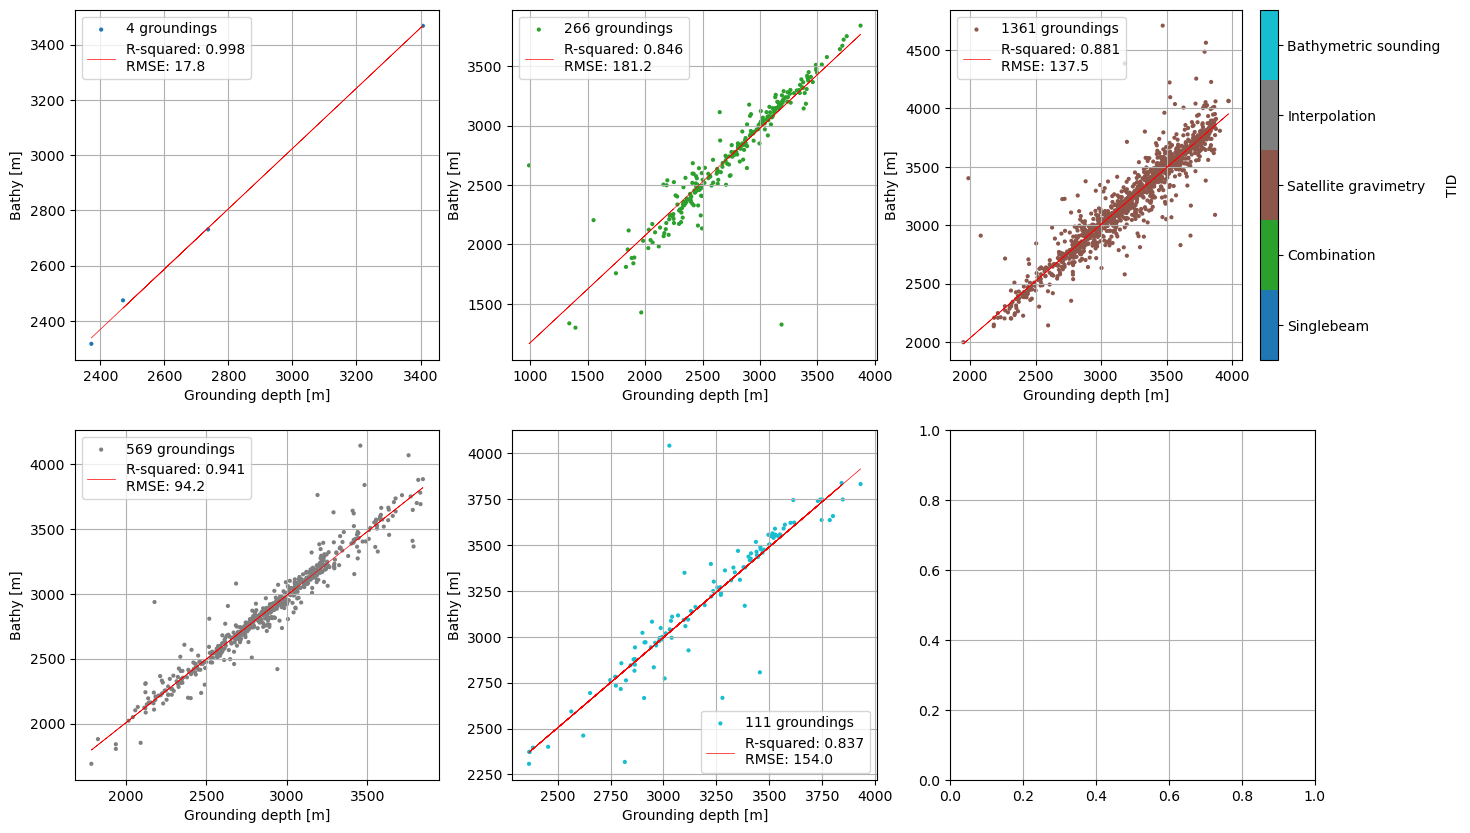

In [67]:
fig,ax = plt.subplots(2,3,figsize=(16,10))

uc = np.array([10, 17, 40, 41, 44]) #np.unique(c)
sc = [tids[i] for i in uc]

k=0
for t in uc:
    lk=int(np.floor(k/3))
    ck=k%3
    #HERE WE TAKE ONLY THE INDEXZ VALUES
    subgebco = gebco.iloc[indexz].query(f'tid=={t}')
    xs=subgebco['ground'].values
    ys=-subgebco['gebco'].values
    cs=subgebco['tid'].values    
    cc = [np.argwhere(i==uc)[0].flatten() for i in cs] 
    res = stats.linregress(xs, ys)

    a=ax[lk,ck].scatter(xs,ys,s=4,c=cc,label=f"{len(xs)} groundings",cmap=plt.get_cmap('tab10',len(uc)),vmin=0,vmax=5)
    ax[lk,ck].plot(xs, res.intercept + res.slope*xs, 'r',linewidth=0.5,label=f"R-squared: {res.rvalue**2:.3f}\nRMSE: {np.sqrt(mean_squared_error(ys, res.intercept + res.slope*xs)):.1f}")
    if ck==2:
        cbar = plt.colorbar(a,label='TID')
        cbar.set_ticks([0.5,1.5,2.5,3.5,4.5],labels=sc)
    
    ax[lk,ck].legend()
    ax[lk,ck].set_xlabel('Grounding depth [m]')
    ax[lk,ck].set_ylabel('Bathy [m]')
    k+=1